***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$ Check for consistency between levels using Bayes' theorem

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_staked # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = DARKNITRO
• Working Directory = g:\My Drive\Work Directory\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:19:05) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.6.0
• Keras Version = 2.6.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_4_1')

# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [26]:
def margin_loss(y_true, y_proba,name):
    y_proba = tf.math.divide(y_proba,tf.reshape(tf.reduce_sum(y_proba,-1),(-1,1),name='reshape'),name='Normalising_Probability'+name)
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw"+name)
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw"+name)
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L"+name)
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss"+name)

    return total_marginloss

def bayesian_loss(y_true, y_pred):
    """
    Bayes' theorem loss function for a model with 3 output branches.
    Calculates the probability using Margin Loss Function and checks for consistency between levels Using Bayes' theorem.
    
    Args:
        y_true (tf.Tensor): true labels
        y_pred (tf.Tensor): predicted labels
        
    Returns:
        tf.Tensor: Loss value
    """
    # y_true_coarse, y_true_medium, y_true_fine = tf.unstack(y_true, axis=1)
    # y_pred_coarse, y_pred_medium, y_pred_fine = tf.unstack(y_pred, axis=1)

    y_true_coarse = y_true[:, :2]
    y_true_medium = y_true[:, 2:9]
    y_true_fine = y_true[:, 9:]

    y_pred_coarse = y_pred[:, :2]
    y_pred_medium = y_pred[:, 2:9]
    y_pred_fine = y_pred[:, 9:]



    # Calculate the Margin loss for each level
    loss_fine = tf.reduce_mean(margin_loss(y_true_fine, y_pred_fine,"c")) # Margin loss for fine
    loss_medium = tf.reduce_mean(margin_loss(y_true_medium, y_pred_medium,"m")) # Margin loss for medium
    loss_coarse = tf.reduce_mean(margin_loss(y_true_coarse, y_pred_coarse,"f")) # Margin loss for coarse
    
    # Check for consistency between levels using Bayes' theorem
    # Convert predicted probabilities to log probabilities for numerical stability
    log_pred_fine = tf.math.log(tf.clip_by_value(y_pred_fine, 1e-10, 1.0))
    log_pred_medium = tf.math.log(tf.clip_by_value(y_pred_medium, 1e-10, 1.0))
    log_pred_coarse = tf.math.log(tf.clip_by_value(y_pred_coarse, 1e-10, 1.0))

    # bayesian_loss_fine_medium = tf.reduce_sum(y_true_medium * tf.math.log(tf.clip_by_value(y_pred_fine, 1e-10, 1.0)), axis=1)
    
    # Calculate the probability of fine level class belonging to medium level
    prob_fine_to_medium = tf.reduce_sum(tf.reduce_max(y_true_fine, axis=1) * tf.reduce_max(log_pred_medium, axis=1), axis=1)
    
    # Calculate the probability of medium level class belonging to coarse level
    prob_medium_to_coarse = tf.reduce_sum(tf.reduce_max(y_true_medium, axis=1) * tf.reduce_max(log_pred_coarse, axis=1), axis=1)
    
    # Add the probabilities to the loss
    loss_fine += tf.reduce_mean(prob_fine_to_medium)
    loss_medium += tf.reduce_mean(prob_medium_to_coarse)
    
    # Return the total loss
    return loss_fine + loss_medium + loss_coarse

# def bayesian_loss(y_true, y_pred):
    
#     """
#     Loss function that implements Bayes' theorem for a 3-output B-CNN model.

#     Args:
#         y_true: Tensor of true labels, shape (batch_size, num_classes)
#         y_pred: Tensor of predicted labels, shape (batch_size, num_classes)

#     Returns:
#         loss: Scalar tensor representing the loss value
#     """
#     # Split true and predicted labels into fine, medium, and coarse level labels
#     y_true_coarse = y_true[:, :2]
#     y_true_medium = y_true[:, 2:9]
#     y_true_fine = y_true[:, 9:]
#     y_pred_coarse = y_pred[:, :2]
#     y_pred_medium = y_pred[:, 2:9]
#     y_pred_fine = y_pred[:, 9:]

#     # Check if predicted class in fine level belongs to medium level
#     p_medium_given_fine = y_pred_fine / tf.reduce_sum(y_pred_fine, axis=1, keepdims=True)
#     loss_medium_given_fine = -tf.reduce_sum(y_true_medium * tf.math.log(tf.clip_by_value(p_medium_given_fine, 1e-10, 1.0)))

#     # Check if predicted class in medium level belongs to coarse level
#     p_coarse_given_medium = y_pred_medium / tf.reduce_sum(y_pred_medium, axis=1, keepdims=True)
#     loss_coarse_given_medium = -tf.reduce_sum(y_true_coarse * tf.math.log(tf.clip_by_value(p_coarse_given_medium, 1e-10, 1.0)))

# #     # Calculate the Margin loss for each level
# #     loss_fine = tf.reduce_mean(margin_loss(y_true_fine, y_pred_fine,"c")) # Margin loss for fine
# #     loss_medium = tf.reduce_mean(margin_loss(y_true_medium, y_pred_medium,"m")) # Margin loss for medium
# #     loss_coarse = tf.reduce_mean(margin_loss(y_true_coarse, y_pred_coarse,"f")) # Margin loss for coarse

#     # Calculate categorical cross-entropy loss for fine, medium, and coarse levels
#     cross_entropy_fine = tf.reduce_sum(y_true_fine * tf.math.log(tf.clip_by_value(y_pred_fine, 1e-10, 1.0)))
#     cross_entropy_medium = tf.reduce_sum(y_true_medium * tf.math.log(tf.clip_by_value(y_pred_medium, 1e-10, 1.0)))
#     cross_entropy_coarse = tf.reduce_sum(y_true_coarse * tf.math.log(tf.clip_by_value(y_pred_coarse, 1e-10, 1.0)))

#     # Combine the losses and return the total loss
#     loss = cross_entropy_fine + cross_entropy_medium + cross_entropy_coarse + loss_medium_given_fine + loss_coarse_given_medium
#     return -loss  # Return negative of the total loss for minimization


In [27]:
# Generate sample data for true and predicted labels
num_classes_coarse = 2
num_classes_medium = 7
num_classes_fine = 10
batch_size = 32

# Generate random true labels
y_true_coarse = tf.one_hot(tf.random.uniform((batch_size,), maxval=num_classes_coarse, dtype=tf.int32), depth=num_classes_coarse)
y_true_medium = tf.one_hot(tf.random.uniform((batch_size,), maxval=num_classes_medium, dtype=tf.int32), depth=num_classes_medium)
y_true_fine = tf.one_hot(tf.random.uniform((batch_size,), maxval=num_classes_fine, dtype=tf.int32), depth=num_classes_fine)
y_true = tf.concat([y_true_coarse, y_true_medium, y_true_fine], axis=1)


In [28]:

# Generate random predicted labels
y_pred_coarse = tf.random.uniform((batch_size, num_classes_coarse))
y_pred_medium = tf.random.uniform((batch_size, num_classes_medium))
y_pred_fine = tf.random.uniform((batch_size, num_classes_fine))
y_pred = tf.concat([y_pred_coarse, y_pred_medium, y_pred_fine], axis=1)

# Calculate the loss using the bayes_margin_loss function
loss = bayesian_loss(y_true, y_pred)

# Print the loss value
print("Loss:", loss.numpy())

InvalidArgumentError: Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Sum]

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    # input_shape_yc = dataset['y_train_coarse'].shape[1:]
    # input_shape_ym = dataset['y_train_medium'].shape[1:]
    # input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    stacked_output = keras.layers.Concatenate(axis=1,name="prediction_staked")([pred_c, pred_m, pred_f])

    model = keras.Model(inputs= x_input,
                        outputs= stacked_output,
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    # model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
    #                           lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
    #                           dataset['tree']))

    model.compile(optimizer='adam',
                  loss = bayesian_loss,
                  metrics={'prediction_staked': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        Input_Image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 32, 32, 64)   36928       batch_normalization[0][0]        
_________________________________________________________________________________________

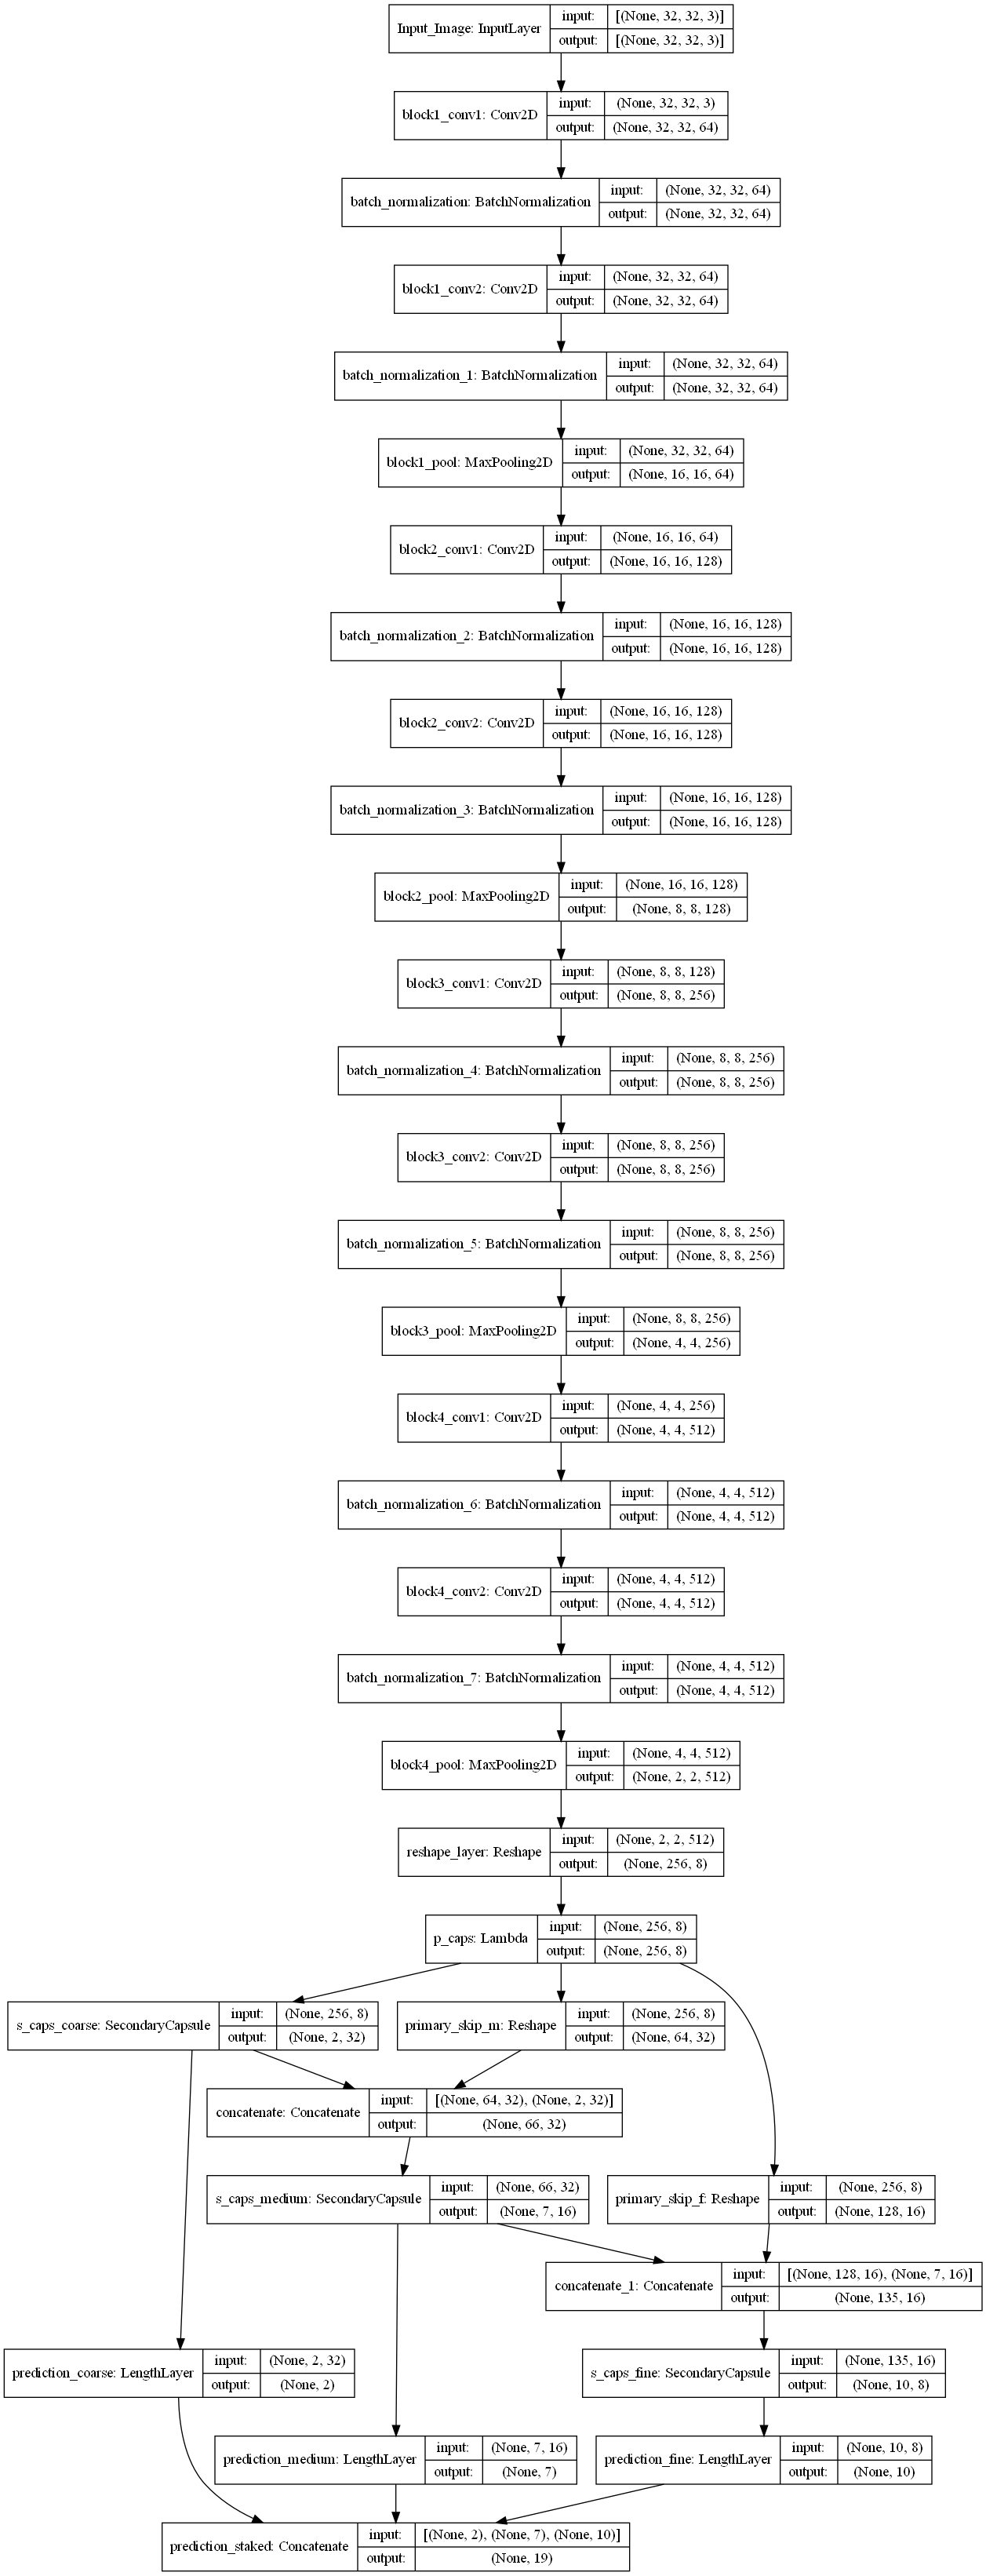

In [12]:
model.summary()
keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_staked.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
level1_labels = tf.constant(dataset['y_train_coarse'])  # Shape: (3, 2)
level2_labels = tf.constant(dataset['y_train_medium'])  # Shape: (3, 7)
level3_labels = tf.constant(dataset['y_train_fine'])  # Shape: (3, 10)

# Concatenate the labels along axis 1
concatenated_labels = tf.concat([level1_labels, level2_labels, level3_labels], axis=1)

In [16]:
# model_save_dir = str(directory+'/trained_model.h5')
# try:
#     model.load_weights(model_save_dir)
# except:
#     history = model.fit(training_generator,
#                         steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
#                         epochs = train_params["n_epochs"],
#                         validation_data = (dataset['x_test'],
#                                            [[dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]]),
#                         callbacks = [tb,log,change_lw,lr_decay,checkpoint],
#                         verbose=1)
#     model.save_weights(model_save_dir)
history = model.fit(x= dataset['x_train'],
                    y= concatenated_labels,
                    epochs = train_params["n_epochs"],
                    # validation_data = (dataset['x_test'],
                    #                     [[dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    verbose=1)
model.save_weights(model_save_dir)

Epoch 1/100


ValueError: in user code:

    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\tasr1\AppData\Local\Temp/ipykernel_13736/2715714449.py:82 bayesian_loss  *
        loss_medium_given_fine = -tf.reduce_sum(y_true_medium * tf.math.log(tf.clip_by_value(p_medium_given_fine, 1e-10, 1.0)))
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1383 binary_op_wrapper
        raise e
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1710 _mul_dispatch
        return multiply(x, y, name=name)
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_math_ops.py:6244 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\tasr1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 7 and 10 for '{{node bayesian_loss/mul}} = Mul[T=DT_FLOAT](bayesian_loss/strided_slice_1, bayesian_loss/Log)' with input shapes: [?,7], [?,10].


In [ ]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

In [ ]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [ ]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [ ]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

In [ ]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [ ]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )